In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import joblib
import time

In [2]:
df = pd.read_csv(r"C:\Users\shraw\Downloads\Liver Patient Dataset (LPD)_train.csv\Liver Patient Dataset (LPD)_train.csv", encoding="ISO-8859-1")
print(f"Original dataset size: {len(df)}")

Original dataset size: 30691



Class Distribution:
Result
1    21917
2     8774
Name: count, dtype: int64

Imbalance Ratio: 2.50


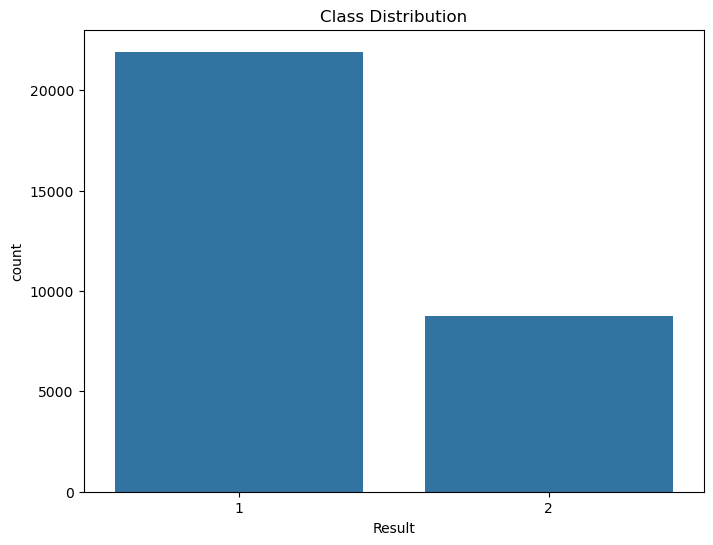

In [3]:
print("\nClass Distribution:")
class_dist = df['Result'].value_counts()
print(class_dist)
imbalance_ratio = class_dist.max() / class_dist.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")


plt.figure(figsize=(8, 6))
sns.countplot(x=df['Result'])
plt.title('Class Distribution')
plt.show()

Result,1,2
Gender of the patient,,
Female,5553,2250
Male,15742,6244


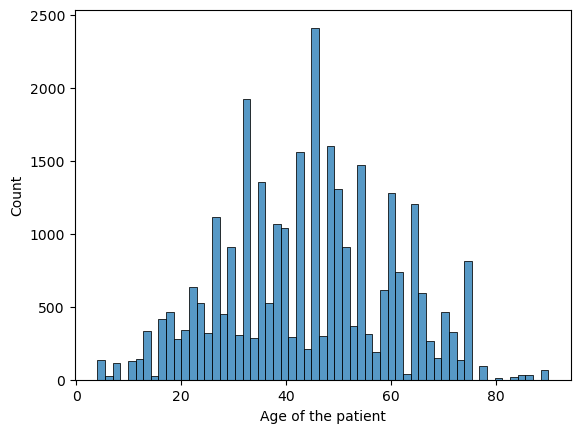

In [4]:
sns.histplot(df['Age of the patient'])
pd.crosstab(df['Gender of the patient'],df['Result'])

<Axes: xlabel='Direct Bilirubin', ylabel='Density'>

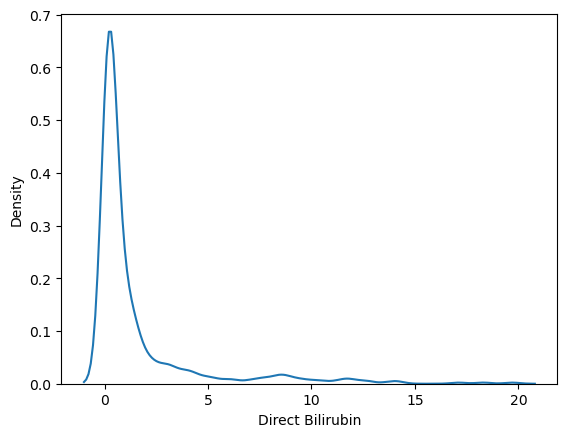

In [5]:
sns.kdeplot(df['Direct Bilirubin'])

<Axes: xlabel='Gender of the patient', ylabel='count'>

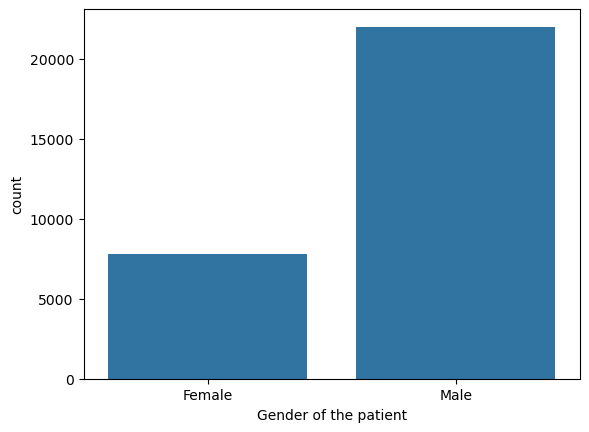

In [6]:
sns.countplot(x='Gender of the patient',data=df)

<Axes: xlabel='Gender of the patient', ylabel='Total Bilirubin'>

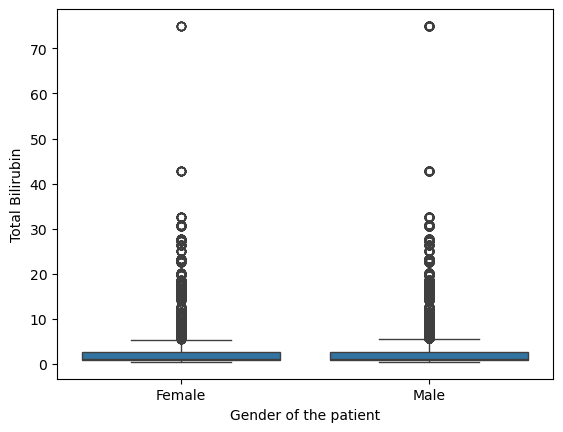

In [7]:
sns.boxplot(x='Gender of the patient',y='Total Bilirubin',data=df)

<Axes: xlabel='Total Bilirubin', ylabel='Direct Bilirubin'>

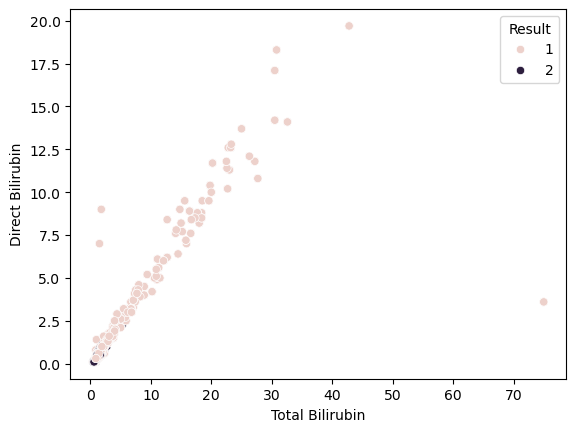

In [8]:
sns.scatterplot(x='Total Bilirubin',y='Direct Bilirubin',data=df,hue='Result')

In [9]:
df = df.drop_duplicates()
print(f"After removing duplicates: {len(df)}")

After removing duplicates: 19368


In [10]:
X = df.drop('Result', axis=1)
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")


Training set: (15494, 10)
Testing set: (3874, 10)


In [11]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [12]:
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


X_train_processed = final_pipeline.fit_transform(X_train)
X_test_processed = final_pipeline.transform(X_test)

print(f"Processed training set: {X_train_processed.shape}")
print(f"Processed testing set: {X_test_processed.shape}")

Processed training set: (15494, 10)
Processed testing set: (3874, 10)


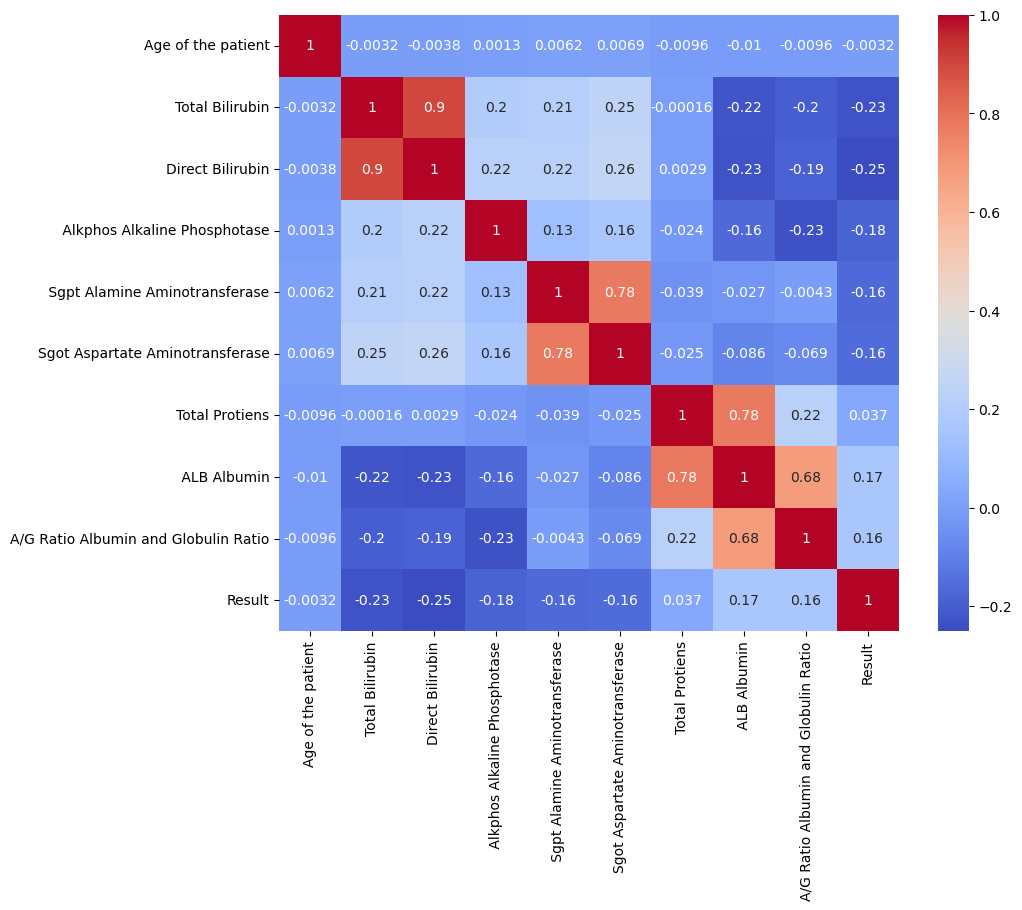

In [13]:
df_corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.show()

In [14]:
over = SMOTE(sampling_strategy=0.7, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

X_res, y_res = over.fit_resample(X_train_processed, y_train)
X_res, y_res = under.fit_resample(X_res, y_res)

print("Final resampled distribution:")
print(pd.Series(y_res).value_counts())

Final resampled distribution:
Result
1    9667
2    7734
Name: count, dtype: int64


In [15]:
le = LabelEncoder()
y_res_encoded = le.fit_transform(y_res)
y_test_encoded = le.transform(y_test)

In [16]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100, max_depth=5),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, max_depth=3, learning_rate=0.1)
}

results = {}

In [17]:
for name, model in models.items():
    print(f'\nTraining {name}...')
    start_time = time.time()
    
    model.fit(X_res, y_res_encoded)
    
    y_test_pred = model.predict(X_test_processed)
    y_test_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test_encoded, y_test_pred)
    f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')
    roc_auc = roc_auc_score(y_test_encoded, y_test_proba) if y_test_proba is not None else None
    
    results[name] = {
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc,
        'training_time': time.time() - start_time
    }
    
    print(f"Completed {name} in {results[name]['training_time']:.2f} seconds")
    print(f"Test Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'F1-Score': [results[name]['f1'] for name in results.keys()],
    'ROC-AUC': [results[name]['roc_auc'] for name in results.keys()],
    'Training Time (s)': [results[name]['training_time'] for name in results.keys()]
}).sort_values('Accuracy', ascending=False)

print("\nModel Performance Comparison:")
print(results_df)

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]


Training Logistic Regression...
Completed Logistic Regression in 0.19 seconds
Test Accuracy: 0.6193, F1-Score: 0.6345, ROC-AUC: 0.7481

Training Random Forest...
Completed Random Forest in 2.47 seconds
Test Accuracy: 0.7161, F1-Score: 0.7291, ROC-AUC: 0.8791

Training XGBoost...
Completed XGBoost in 0.19 seconds
Test Accuracy: 0.8224, F1-Score: 0.8298, ROC-AUC: 0.9406

Model Performance Comparison:
                 Model  Accuracy  F1-Score   ROC-AUC  Training Time (s)
2              XGBoost  0.822406  0.829809  0.940601           0.193089
1        Random Forest  0.716056  0.729074  0.879130           2.472858
0  Logistic Regression  0.619257  0.634454  0.748079           0.190860


In [18]:
class SerializablePipeline:
    def __init__(self, preprocessor, model, label_encoder):
        self.preprocessor = preprocessor
        self.model = model
        self.label_encoder = label_encoder
    
    def predict(self, X):
        X_processed = self.preprocessor.transform(X)
        return self.model.predict(X_processed)
    
    def predict_proba(self, X):
        X_processed = self.preprocessor.transform(X)
        return self.model.predict_proba(X_processed)

serializable_pipeline = SerializablePipeline(final_pipeline, best_model, le)


joblib.dump(serializable_pipeline, 'liver_disease_model.pkl')
print(f"\nSaved best model: {best_model_name} with accuracy: {results[best_model_name]['accuracy']:.4f}")



Saved best model: XGBoost with accuracy: 0.8224


In [19]:
print(f"\n{'='*80}")
print("FINAL ANALYSIS:")
print(f"{'='*80}")
print(f"   - Best model: {best_model_name}")
print(f"   - Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   - F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"   - ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"{'='*80}")


FINAL ANALYSIS:
   - Best model: XGBoost
   - Accuracy: 0.8224
   - F1-Score: 0.8298
   - ROC-AUC: 0.9406


In [20]:
model = joblib.load('liver_disease_model.pkl')

new_patient_data = pd.DataFrame({
    'Age of the patient': [45.0],
    'Gender of the patient': ['Male'],
    'Total Bilirubin': [1.2],
    'Direct Bilirubin': [0.3],
    '\xa0Alkphos Alkaline Phosphotase': [187.0],  
    '\xa0Sgpt Alamine Aminotransferase': [25.0],     
    'Sgot Aspartate Aminotransferase': [30.0],
    'Total Protiens': [6.8],
    '\xa0ALB Albumin': [3.5],                      
    'A/G Ratio Albumin and Globulin Ratio': [1.1]
})


print("Columns the model expects:")
print(new_patient_data.columns.tolist())

prediction = model.predict(new_patient_data)
probability = model.predict_proba(new_patient_data)

print(f"\nPrediction: {prediction[0]}")
print(f"Probability: {probability[0]}")
print(f"Interpretation: {'Liver Disease' if prediction[0] == 1 else 'No Liver Disease'}")

Columns the model expects:
['Age of the patient', 'Gender of the patient', 'Total Bilirubin', 'Direct Bilirubin', '\xa0Alkphos Alkaline Phosphotase', '\xa0Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase', 'Total Protiens', '\xa0ALB Albumin', 'A/G Ratio Albumin and Globulin Ratio']

Prediction: 1
Probability: [0.43563914 0.56436086]
Interpretation: Liver Disease
